## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

## Utils

In [2]:
def load_matrix(path: str, verbose: bool = True, num_to_print: int = 3) -> np.ndarray:
    matrix = np.loadtxt(path, delimiter=",")
    if verbose:
        print("Loaded matrix from", os.path.basename(path))
        print("Shape:", matrix.shape)
        num_to_print = min(num_to_print, len(matrix))
        print("Example:\n", matrix[:num_to_print], end="\n\n")
    return matrix

In [3]:
%cd ../../

/home/shkarupa/Documents/Semester6/Coursework/parallel-gradient-descent


## Generate data

In [4]:
!python demo/gen_data.py --help

Generate train and test data for linear regression model

options:
  -h, --help            show this help message and exit
  -t , --num-train      number of train samples (default: 1000)
  -e , --num-eval       number of evaluation samples (default: 0)
  -f , --num-features   number of per sample features (default: 10)
  -s , --seed           seed that make data generation deterministic (default:
                        None)
  -o , --out-dir        path to directory where generated data will be stored
                        (default: ./data)


In [5]:
!python demo/gen_data.py --num-train 10000 --num-eval 1000 --num-features 50 --seed 42 --out-dir data

## Look at data

In [6]:
!ls data

x_eval.csv  x_train.csv  y_eval.csv  y_train.csv


In [7]:
x_train = load_matrix("data/x_train.csv")
y_train = load_matrix("data/y_train.csv")

x_eval = load_matrix("data/x_eval.csv")
y_eval = load_matrix("data/y_eval.csv")

Loaded matrix from x_train.csv
Shape: (10000, 50)
Example:
 [[ 2.95968714 -1.55389604 -0.48789272 -1.36831184 -0.20263477  1.41635756
  -0.90313868 -0.95597179 -0.12810009 -0.02263904  1.93091826 -0.32607787
   0.98447725  0.20676263  0.98023936 -0.03414261 -0.87678792 -0.74727258
  -0.89908933  0.09703152  0.45763206 -0.30576507  0.63384171  0.33568143
   1.48803568 -1.18529753  0.84500771 -0.67708658 -0.83827108  1.77233907
   1.20185808 -1.35613327  0.02696155 -0.07453549 -0.11018498 -1.02105208
   1.313818   -0.50045726 -1.38283007 -0.25538025  1.10290659 -0.43155701
  -1.78457899 -1.02707377  0.63928598  0.25682739 -0.99758205 -0.7624109
   0.236132    0.39076224]
 [-0.27781133 -0.91610651  0.42757895 -0.10941617  0.51962799  1.59734786
   0.0355245  -0.30976788  1.09694687 -0.95203685  0.23673151 -0.83714568
   0.57837305 -0.10084802  0.13556278  0.93543662  0.26276161 -0.35659344
   1.11567523 -0.00508411  0.91885756  1.30832185 -2.06085119 -0.1050777
   2.12520861  1.56262663 -

## Run Linear regression

In [8]:
!./build/bin/gradient_descent -h

Linear regression config:

CLI options:
  -h [ --help ]                        produce help message
  -c [ --config ] arg                  path to config file

Algorithm options:
  -i [ --input-path ] arg              path to input CSV file
  -t [ --target-path ] arg             path to target CSV file
  -e [ --eval-path ] arg               path to evaluation CSV file
  -o [ --out-path ] arg (=output.csv)  path to output CSV file
  --cost-path arg                      path to cost CSV file
  -p [ --parallel ]                    wether to use parallel or serial SGD
  -n [ --num-epochs ] arg (=1000)      number of training epochs
  -l [ --lr ] arg (=0.001)             learning rate
  -w [ --weight-decay ] arg (=0.01)    L2 regularization lambda term
  --normalize                          wether to normalize input
  --num-threads arg (=11)              number of threads to use for parallel 
                                       SGD
  --num-step-epochs arg (=1)           number of epochs 

### SGD

In [9]:
!cat examples/serial_config.cfg

input-path = data/x_train.csv
target-path = data/y_train.csv
eval-path = data/x_eval.csv
out-path = output/serial_pred.csv
cost-path = output/serial_cost.csv
parallel = false
num-epochs = 10000
lr = 0.001
weight-decay = 0.01
normalize = true


In [10]:
!./build/bin/gradient_descent --config examples/serial_config.cfg

Time: 2026 ms


In [11]:
y_pred_sgd = load_matrix("output/serial_pred.csv", verbose=False)

In [12]:
print("MSE:", mean_squared_error(y_pred_sgd.squeeze(), y_eval))

MSE: 16.35216516327586


### Parallel SGD

In [13]:
!cat examples/parallel_config.cfg

input-path = data/x_train.csv
target-path = data/y_train.csv
eval-path = data/x_eval.csv
out-path = output/parallel_pred.csv
cost-path = output/parallel_cost.csv
parallel = true
num-epochs = 10000
lr = 0.001
weight-decay = 0.01
normalize = true
num-threads = 11
num-step-epochs = 100


In [14]:
!./build/bin/gradient_descent --config examples/parallel_config.cfg

Time: 484 ms


In [15]:
y_pred_parallel_sgd = load_matrix("output/parallel_pred.csv", verbose=False)

In [16]:
print("MSE:", mean_squared_error(y_pred_parallel_sgd, y_eval))

MSE: 16.621072667443595


### Sklearn

In [17]:
regressor = make_pipeline(StandardScaler(), LinearRegression())
# regressor = make_pipeline(
#     StandardScaler(), 
#     SGDRegressor(alpha=0.01, learning_rate="constant", eta0=0.001),
# )
# start = time.perf_counter_ns()
regressor.fit(x_train, y_train.squeeze())
# end = time.perf_counter_ns()
# print("SGD:", (end - start) / 1e6, "ms")

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [18]:
y_pred = regressor.predict(x_eval)

In [19]:
print("MSE:", mean_squared_error(y_pred, y_eval))

MSE: 16.351442080312363


## Cost decay comparison

### Prepare data

In [20]:
parallel_cost = load_matrix("output/parallel_cost.csv", verbose=False)
serial_cost = load_matrix("output/serial_cost.csv", verbose=False)

num_parallel = parallel_cost.shape[0]
num_serial = serial_cost.shape[0]

serial_idxs = np.arange(num_serial)
parallel_idxs = np.linspace(0, num_serial, num_parallel)

### Plot

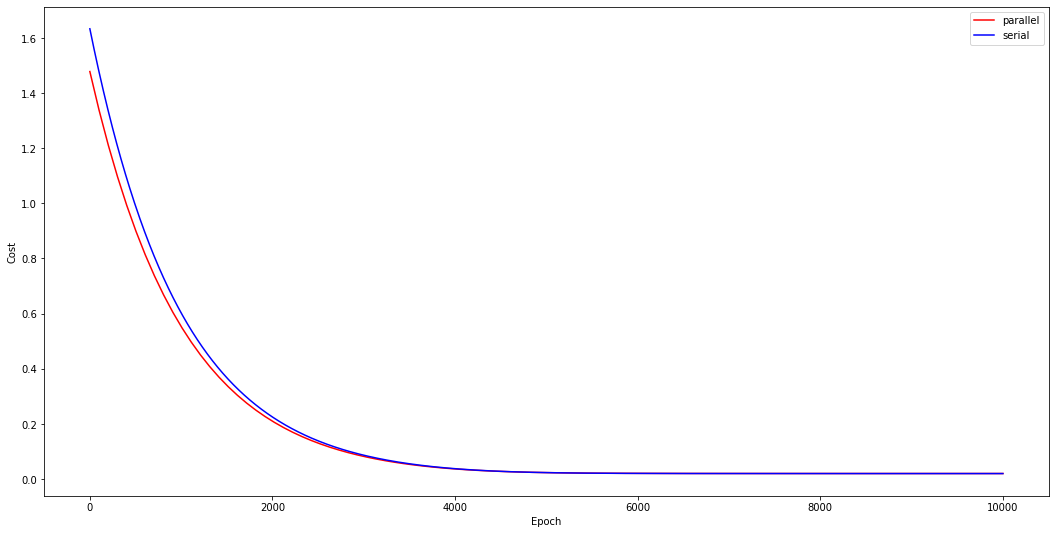

In [21]:
plt.figure(figsize=(18, 9))
plt.plot(parallel_idxs, parallel_cost, color="red", label="parallel")
plt.plot(serial_idxs, serial_cost, color="blue", label="serial")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.show()

## Benchmark

In [22]:
!python demo/benchmark.py -h

SGD benchmark

positional arguments:
  binary                path to C++ gradient descent project executable

options:
  -h, --help            show this help message and exit
  -c , --config         path to benchmark JSON config file (default: None)
  -s , --serial-config 
                        path to serial SGD INI config file (default: None)
  -p , --parallel-config 
                        path to parallel SGD INI config file (default: None)
  -t , --temp-dir       path to temporary dir that will be removed after
                        extection (default: benchmark_data)


In [23]:
!cat examples/benchmark_config.json

{
  "data": {
    "param_set": [
      {"num-train": 2000, "num-features": 25},
      {"num-train": 5000, "num-features": 50},
      {"num-train": 10000, "num-features": 100}
    ]
  },
  "sgd": {
    "param_set": [
      {"num-threads": 15, "num-step-epochs": 100},
      {"num-threads": 23, "num-step-epochs": 100}
    ],
    "param_space": {
      "num-threads": [3, 7, 11],
      "num-step-epochs": [10, 100]
    }
  }
}

In [24]:
!python demo/benchmark.py build/bin/gradient_descent \
    --serial-config examples/serial_config.cfg \
    --parallel-config examples/parallel_config.cfg \
    --config examples/benchmark_config.json

Data params: num-train=2000, num-features=25
Serial (): 243.0
Parallel (num-threads=15, num-step-epochs=100): 78.0
Parallel (num-threads=23, num-step-epochs=100): 68.0
Parallel (num-threads=3, num-step-epochs=10): 173.0
Parallel (num-threads=3, num-step-epochs=100): 137.0
Parallel (num-threads=7, num-step-epochs=10): 124.0
Parallel (num-threads=7, num-step-epochs=100): 104.0
Parallel (num-threads=11, num-step-epochs=10): 275.0
Parallel (num-threads=11, num-step-epochs=100): 59.0
Data params: num-train=5000, num-features=50
Serial (): 993.0
Parallel (num-threads=15, num-step-epochs=100): 267.0
Parallel (num-threads=23, num-step-epochs=100): 210.0
Parallel (num-threads=3, num-step-epochs=10): 444.0
Parallel (num-threads=3, num-step-epochs=100): 372.0
Parallel (num-threads=7, num-step-epochs=10): 436.0
Parallel (num-threads=7, num-step-epochs=100): 349.0
Parallel (num-threads=11, num-step-epochs=10): 431.0
Parallel (num-threads=11, num-step-epochs=100): 237.0
Data params: num-train=10000,